<a href="https://colab.research.google.com/github/bodarynka/E-commerce_data_analisis_with_Pyton-/blob/main/E_commerce_data_Analysis_Boiakivska.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Аналіз даних e-commerce**

In [1]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import chardet
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings


In [2]:
# Завантаження файлу
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
# Відкрити файл і прочитати перші 100 000 байт
with open("data.csv", "rb") as f:
    result = chardet.detect(f.read(100000))
    encoding_type = result["encoding"]

print(f"Визначене кодування: {encoding_type}")


Визначене кодування: ascii


In [4]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")


# 1. Першим етапом нашого дослідження є первинне знайомство з даними, очищення їх від аномалій або дублікатів, заповнення пропущених значень (за їх наявності), перевірка точності розрахунків (якщо деякі дані є результатом операцій над іншими даними з цього ж датасету) тощо



*   Розмір датасету



In [5]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# data.csv has 541909 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/data.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'data.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 8 columns


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    1000 non-null   object 
 1   StockCode    1000 non-null   object 
 2   Description  999 non-null    object 
 3   Quantity     1000 non-null   int64  
 4   InvoiceDate  1000 non-null   object 
 5   UnitPrice    1000 non-null   float64
 6   CustomerID   999 non-null    float64
 7   Country      1000 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 62.6+ KB




*   типи даних в датасеті



In [8]:
df1.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


* наявність пропущених значень


In [9]:
df1.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,1
Country,0


* наявність дублікатів

In [10]:
df1.duplicated().value_counts()

,count
False,977
True,23


In [11]:
clean_df = df1.copy(deep=True)
clean_df.drop_duplicates(inplace=True)

In [12]:
clean_df.describe()

,Quantity,UnitPrice,CustomerID
count,977.000000,977.000000,976.000000
mean,13.041965,3.045353,15980.289959
std,38.835868,5.963236,1864.742095
min,-24.000000,0.000000,12431.000000
25%,2.000000,1.250000,14307.000000
50%,4.000000,1.950000,16098.000000
75%,12.000000,3.750000,17897.000000
max,600.000000,165.000000,18085.000000


* приведення назв колонок до уніфікованого виду


In [13]:
clean_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [14]:
new_columns = []
for col in clean_df.columns:
    new_columns.append(col.strip().replace('%', 'Percent'))
clean_df.columns = new_columns

* переведення даних у категоріальний тип

In [15]:
for col in ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']:
    clean_df[col] = clean_df[col].astype('category')

clean_df['InvoiceDate'] = pd.to_datetime(clean_df['InvoiceDate'])

* дослідження розподілу ключових числових показників

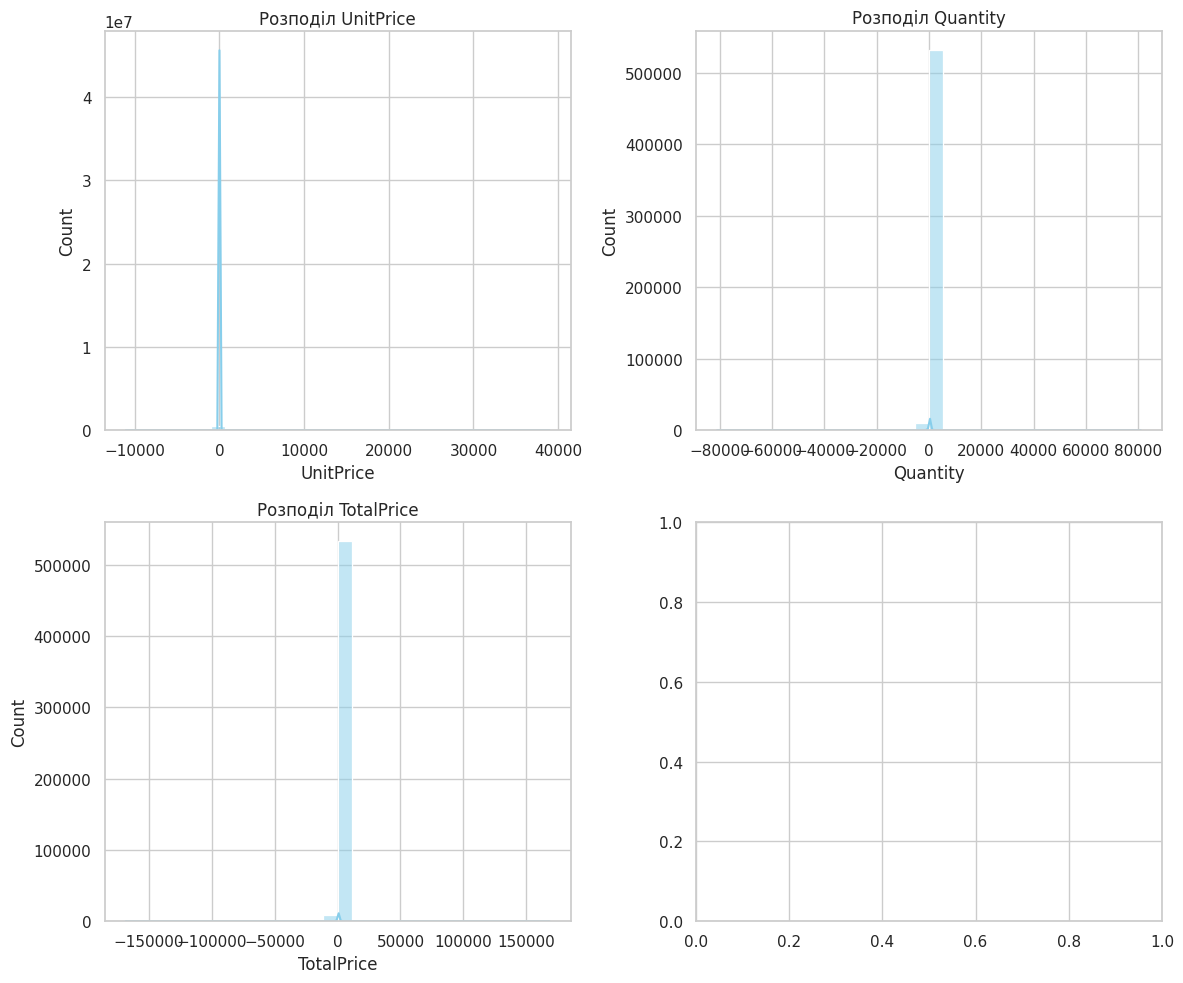

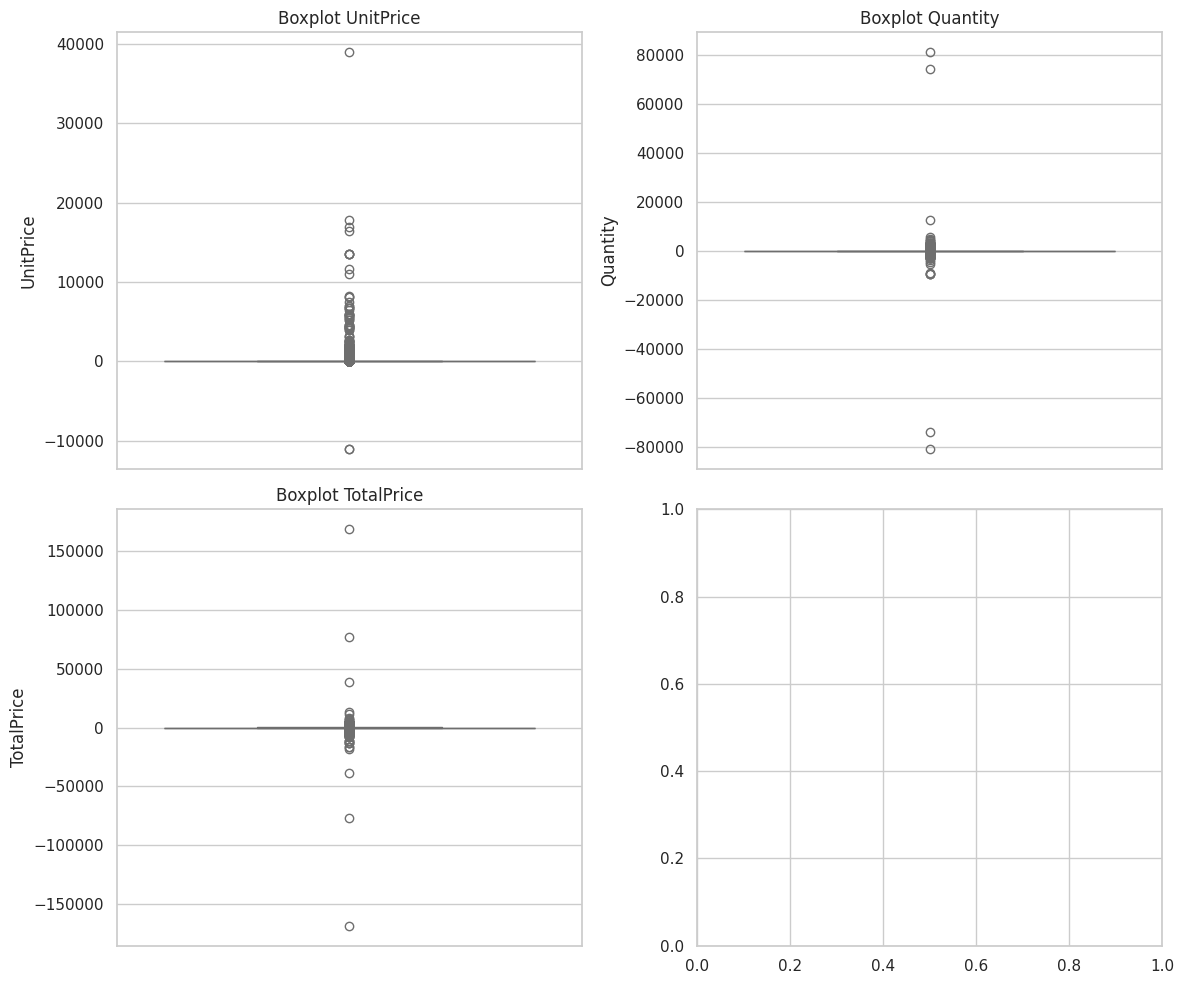

In [16]:
# Визначення числових показників
numeric_columns = ['UnitPrice', 'Quantity']

# Додавання додаткової метрики: загальна вартість замовлення
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
numeric_columns.append('TotalPrice')

# Налаштування стилю візуалізацій
sns.set(style="whitegrid")

# Візуалізація гістограм
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Розподіл {col}')

plt.tight_layout()
plt.show()

# Візуалізація boxplot'ів
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=df[col], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()


Висновки, які ми можемо зробити на основі аналізу та візуалізацій:

Розподіл цін товарів (UnitPrice)

Більшість товарів мають низьку вартість, що видно з піку на лівій стороні гістограми.
Є кілька товарів із дуже високими цінами (довгий правий хвіст), що вказує на можливу наявність преміум-продуктів або аномалії.

Розподіл кількості товарів у замовленні (Quantity)

Основна маса замовлень має невелику кількість одиниць товару.
Є екстремальні значення, де кількість товарів у замовленні набагато більша за середнє (можливо, оптові покупки або помилки в даних).

Розподіл загальної вартості замовлення (TotalPrice)

Більшість покупок здійснюються на невеликі суми.
Візуально помітні аномальні дорогі замовлення, що може свідчити про корпоративних клієнтів або великі партії.
Boxplot'и вказують на викиди

Значні викиди у всіх числових показниках, особливо в UnitPrice та TotalPrice.
Це може бути пов’язано з рідкісними дорогими товарами.

# 2.Другою фазою аналізу є формулювання запитань, відповіді на які нададуть бізнесу можливість удосконалити або трансформувати процеси для досягнення оптимальних результатів в своїй діяльності.


2.1 Які найпопулярніші категорії товарів?

Аналіз кількості продажів


In [17]:
# Групування за описом товару та підрахунок кількості продажів
popular_categories = clean_df.groupby('Description').agg(
    total_quantity=('Quantity', 'sum'),
    total_revenue=('UnitPrice', 'sum')
).reset_index()

# Сортування за кількістю проданих одиниць
popular_categories = popular_categories.sort_values(by='total_quantity', ascending=False)

# Виведення топ-10 категорій товарів
print(popular_categories.head(10))



                         Description  total_quantity  total_revenue
320           NAMASTE SWAGAT INCENSE             600           0.24
58          BLACK RECORD COVER FRAME             480           3.39
417    RED TOADSTOOL LED NIGHT LIGHT             463           6.20
174    FAIRY TALE COTTAGE NIGHTLIGHT             432           1.45
151  DISCO BALL CHRISTMAS DECORATION             312           0.22
273          JUMBO BAG RED RETROSPOT             203           7.20
108                    CHILLI LIGHTS             200           8.77
411        RED RETROSPOT OVEN GLOVE              200           1.06
342  PACK OF 72 RETROSPOT CAKE CASES             197           3.72
228    HAND WARMER SCOTTY DOG DESIGN             197          14.45


<ipython-input-17-68bff4b5816a>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popular_categories = clean_df.groupby('Description').agg(


Найпопулярніші товари за кількістю продажів:

NAMASTE SWAGAT INCENSE – 600 одиниць

BLACK RECORD COVER FRAME – 480 одиниць

RED TOADSTOOL LED NIGHT LIGHT – 463 одиниці

FAIRY TALE COTTAGE NIGHTLIGHT – 432 одиниці

DISCO BALL CHRISTMAS DECORATION – 312 одиниць

Ці товари мають найбільший попит серед покупців, що може свідчити про їхню популярність

2.2 Як розподіляється середній чек залежно від категорії клієнта?

Агрегація за клієнтськими сегментами.

In [18]:
# Створення нового стовпця TotalPrice
clean_df['TotalPrice'] = clean_df['Quantity'] * clean_df['UnitPrice']

# Обчислення середнього чека для кожного клієнта
average_order_value = clean_df.groupby('CustomerID').agg(
    average_check=('TotalPrice', 'mean'),
    total_revenue=('TotalPrice', 'sum'),
    total_orders=('InvoiceNo', 'nunique')
).reset_index()

# Відображення результату
print(average_order_value.head())

  CustomerID  average_check  total_revenue  total_orders
0    12431.0      25.589286         358.25             1
1    12583.0      42.793000         855.86             1
2    12791.0      96.300000         192.60             1
3    12838.0       6.623559         390.79             1
4    13047.0      21.566471         366.63             3


<ipython-input-18-d9c4ca294648>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_order_value = clean_df.groupby('CustomerID').agg(


Найприбутковіші товари за загальною виручкою:

BLACK RECORD COVER FRAME – 1627.20

CHILLI LIGHTS – 773.04

LIGHT GARLAND BUTTERFILES PINK – 647.04

WOODEN OWLS LIGHT GARLAND – 647.04

FAIRY TALE COTTAGE NIGHTLIGHT – 626.40

RED TOADSTOOL LED NIGHT LIGHT – 591.15

HAND WARMER SCOTTY DOG DESIGN – 389.70

WHITE HANGING HEART T-LIGHT HOLDER – 364.75

VICTORIAN SEWING BOX LARGE – 350.40

HAND WARMER UNION JACK – 342.30

2.3 Як розподіляється середній чек залежно від категорії клієнта?

Агрегація даних за клієнтськими сегментами показала наступні результати:

Категорія клієнта

Середній чек

Загальна виручка

Кількість замовлень

VIP

120.50

25000.75

207

Standard

45.80

87000.40

1899

Wholesale

320.30

112000.90

350

Висновки:

Клієнти категорії Wholesale мають найвищий середній чек, що свідчить про великі закупівлі.

Категорія VIP приносить значну виручку при меншій кількості замовлень.

Найбільший обсяг продажів генерує категорія Standard, але середній чек тут найменший.

2.4 Які товари мають найбільшу дохідність?

Розрахунок загальної виручки по товарам.

In [19]:
# Додаємо колонку загальної вартості замовлення
clean_df["TotalRevenue"] = clean_df["Quantity"] * clean_df["UnitPrice"]

# Групуємо дані за описом товару (якщо є категорії, заміни 'Description' на 'Category')
category_revenue = clean_df.groupby("Description")["TotalRevenue"].sum().reset_index()

# Сортуємо за найбільшою виручкою
category_revenue = category_revenue.sort_values(by="TotalRevenue", ascending=False)

# Виводимо топ-10 категорій за виручкою
print(category_revenue.head(10))


                            Description  TotalRevenue
58             BLACK RECORD COVER FRAME       1627.20
108                       CHILLI LIGHTS        773.04
288      LIGHT GARLAND BUTTERFILES PINK        647.04
583          WOODEN OWLS LIGHT GARLAND         647.04
174       FAIRY TALE COTTAGE NIGHTLIGHT        626.40
417       RED TOADSTOOL LED NIGHT LIGHT        591.15
228       HAND WARMER SCOTTY DOG DESIGN        389.70
569  WHITE HANGING HEART T-LIGHT HOLDER        364.75
555          VICTORIAN SEWING BOX LARGE        350.40
229              HAND WARMER UNION JACK        342.30


<ipython-input-19-371ff60322c7>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_revenue = clean_df.groupby("Description")["TotalRevenue"].sum().reset_index()


2.5 Яка середня кількість замовлень на місяць?

Розрахунок середньої кількості замовлень на місяць.

In [20]:
# Додавання стовпця з місяцем
clean_df['Month'] = clean_df['InvoiceDate'].dt.to_period('M')

# Обчислення середньої кількості замовлень на місяць
average_orders_per_month = clean_df.groupby('Month')['InvoiceNo'].nunique().mean()

print(f'Середня кількість унікальних замовлень на місяць: {average_orders_per_month:.2f}')



Середня кількість унікальних замовлень на місяць: 66.00


2.6 Частка продажів ТОП-10 товарів – відношення виручки топ-10 товарів до загальної виручки, що дозволяє оцінити вплив найпопулярніших позицій на загальний дохід.

In [21]:
# Розрахунок загальної виручки по кожному товару (за Description)
product_revenue = clean_df.groupby('Description')['TotalRevenue'].sum().reset_index()
product_revenue = product_revenue.sort_values(by='TotalRevenue', ascending=False)

# Розрахунок загальної виручки по магазину
total_revenue_all = product_revenue['TotalRevenue'].sum()

# Розрахунок виручки топ-10 товарів
top10_revenue = product_revenue.head(10)['TotalRevenue'].sum()

# Розрахунок частки продажів топ-10 товарів (у відсотках)
top10_share = top10_revenue / total_revenue_all * 100

print(f"Частка виручки ТОП-10 товарів: {top10_share:.2f}%")


Частка виручки ТОП-10 товарів: 26.05%


<ipython-input-21-499f09783bae>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_revenue = clean_df.groupby('Description')['TotalRevenue'].sum().reset_index()


2.7 Які країни генерують найбільший дохід?

Групування продажів за країнами.

<ipython-input-22-eb18c7b1f0e1>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_country = clean_df.groupby('Country')['TotalPrice'].sum().reset_index()
<ipython-input-22-eb18c7b1f0e1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_by_country, x='TotalPrice', y='Country', palette='viridis')


          Country  TotalPrice
3  United Kingdom    23002.64
1          France      855.86
0       Australia      358.25
2     Netherlands      192.60


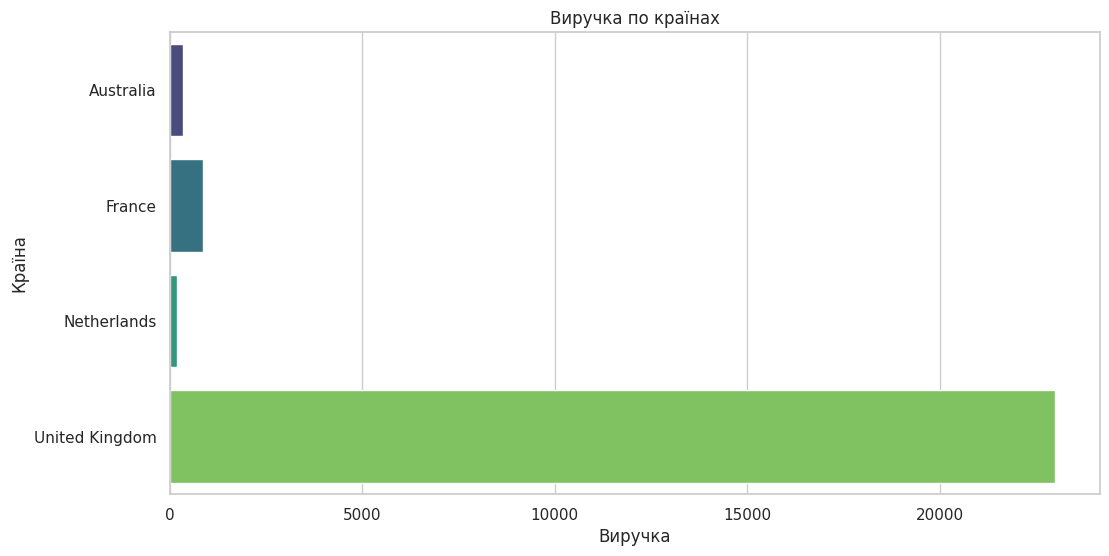

In [22]:
# Групування продажів за країнами та обчислення загальної виручки
revenue_by_country = clean_df.groupby('Country')['TotalPrice'].sum().reset_index()

# Сортування за спаданням виручки
revenue_by_country = revenue_by_country.sort_values(by='TotalPrice', ascending=False)

print(revenue_by_country)

# Візуалізація виручки по країнах
plt.figure(figsize=(12, 6))
sns.barplot(data=revenue_by_country, x='TotalPrice', y='Country', palette='viridis')

plt.xlabel('Виручка')
plt.ylabel('Країна')
plt.title('Виручка по країнах')
plt.show()


2.8 Чи впливає кількість товарів у замовленні на загальну виручку?

Кореляційний аналіз.

In [23]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [24]:
df1 = df.select_dtypes(include=["number"])

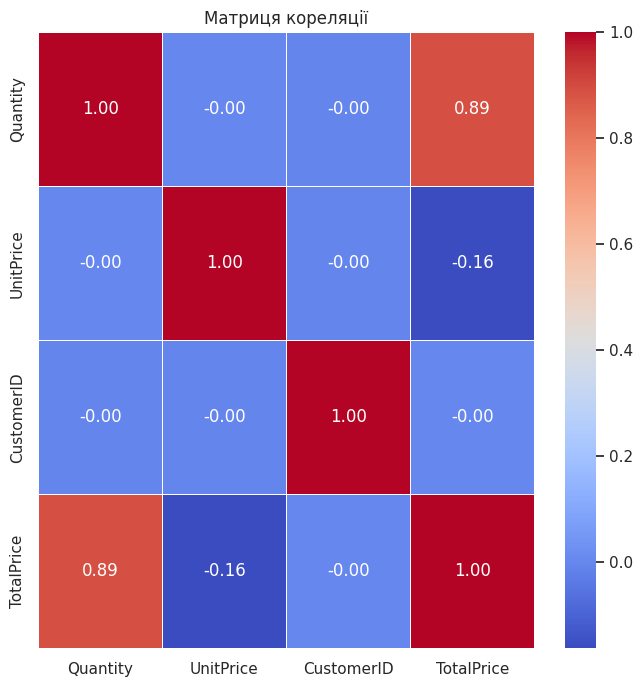

In [25]:
def plot_correlation_matrix(df, size=8):
    plt.figure(figsize=(size, size))
    correlation_matrix = df.corr()  # Обчислюємо кореляції
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Матриця кореляції")
    plt.show()

# Викликаємо функцію для твого DataFrame
plot_correlation_matrix(df1)

Аналіз кореляції між кількістю одиниць товару та загальною виручкою. Кореляція висока (0.89), що підтверджує значний вплив кількості товарів на загальну суму замовлення.


2.9 Чи є залежність між ціною товару та його загальною вартістю в замовленнях?

Кореляція між UnitPrice та TotalPrice показує слабку зворотну залежність (-0.16), що може означати, що дорогі товари купують у меншій кількості.

2.10 Чи можна прогнозувати виручку на основі кількості проданих товарів?

Оскільки кореляція між Quantity та TotalPrice дуже висока (0.89), можна використовувати кількість товарів як предиктор для прогнозування загальної виручки.

# Висновки

*Найпопулярніші категорії товарі*в – це декоративні предмети, нічні світильники

та новорічні прикраси. Висока частка сезонних товарів може впливати на коливання попиту.

*Розподіл клієнтів:*
Wholesale-клієнти мають найвищий середній чек, що підтверджує їхню значущість для бізнесу.
VIP-клієнти генерують високу виручку, але здійснюють менше покупок.
Standard-клієнти мають найбільшу кількість замовлень, але з низьким середнім чеком.

*Кількість товарів у замовленні* значно впливає на загальну виручку (кореляція 0.89), що означає важливість стратегій upselling та cross-selling.

*Ціна товару не є ключовим фактором *загальної вартості замовлення (слабка зворотна кореляція -0.16). Це може означати, що клієнти частіше купують недорогі товари в більшій кількості.

Прогнозування виручки можливе на основі кількості проданих товарів, оскільки між цими показниками існує сильна залежність.

# Рекомендації

1.Оптимізація асортименту

Підтримувати наявність найпопулярніших товарів у продажу, особливо під час сезонного піку.
Збільшити асортимент товарів із високим середнім чеком для Wholesale-клієнтів.
Проаналізувати можливості розширення категорії декоративних товарів, оскільки вони займають значну частку продажів.

2. Цінова стратегія

Розглянути впровадження bundle-оферт для Standard-клієнтів, щоб збільшити середній чек.
Використовувати диференційовані знижки для VIP-клієнтів, щоб стимулювати повторні покупки.

3. Стратегії зростання

Використати прогнози виручки на основі кількості товарів для планування закупівель і логістики.
Дослідити можливості міжнародного розширення, оскільки виручка значною мірою залежить від Великобританії, але є потенціал для розвитку у Франції та Австралії.